In [79]:
#!pip install sentence_transformers
#!pip install keybert
#import nltk
#nltk.download('stopwords')
#!spacy download es_core_news_sm
#nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eduardo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

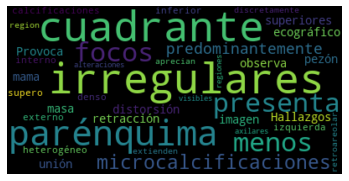

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from keybert import KeyBERT
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from spacy.matcher import Matcher
from spacy.lang.es import Spanish

import os
import stanza 
import docx2txt
from docx2python import docx2python
import docx
import numpy as np
import pandas as pd
import json
from textblob import TextBlob 


sp_nlp = spacy.load('es_core_news_sm')
matcher = Matcher(sp_nlp.vocab)

stop_words = stopwords.words('spanish')
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
modelKeyBERT = KeyBERT('distilbert-base-nli-mean-tokens')

contexto_2 ="""
Hallazgos:

Se observa una masa con distorsión del parénquima en unión de los cuadrantes superiores de con la imagen ecográfico. Provoca retracción del pezón.
El parénquima de la mama izquierda es denso y heterogéneo y presenta al menos 4 focos de microcalcificaciones irregulares, predominantemente en el cuadrante supero externo. 
Presenta al menos 3 focos de calcificaciones irregulares, predominantemente en el cuadrante inferior interno. 
Algunas microcalcificaciones discretamente irregulares se extienden también a la region retroareolar.
No se aprecian alteraciones en las regiones axilares visibles.
 
"""

n_gram_range = (3, 3)
# Extract candidate words/phrases
count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([contexto_2])
candidates = count.get_feature_names()

doc_embedding = model.encode([contexto_2])
candidate_embeddings = model.encode(candidates)

top_n = 5
distances = cosine_similarity(doc_embedding, candidate_embeddings)
keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]

keywords = modelKeyBERT.extract_keywords(contexto_2)

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black", stopwords=stopwords.words('spanish')).generate(contexto_2)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
#plt.show()

model = 'mrm8488/bert-base-spanish-wwm-cased-finetuned-spa-squad2-es'
tokenizer = 'dccuchile/bert-base-spanish-wwm-cased'
nlp = pipeline(
    'question-answering', 
    model = model,
    tokenizer=( tokenizer , {"use_fast": True} )
)

nlp = pipeline('question-answering', model=model, tokenizer=tokenizer)

In [41]:
def get_files_from_path(path):
    #dir_docx="e:/workspace/python/FONDEF/MamAI/src/ejemplos_aleatorios"
    archives = os.listdir(path)
    return archives

def get_text_hall_imp(path_file):
    #path="e:/workspace/python/FONDEF/MamAI/src/ejemplos_aleatorios"    
    str_token =':'
    hallazgos_text = ''
    impresion_text = ''
    #for file in archives :
    print(path_file)
    doc = docx.Document(path_file)
    all_paras = doc.paragraphs
    len(all_paras)
    for para in all_paras:        
       #print("-------")
       #print(para.text)
       if para.text == 'Hallazgos:' :
           str_token ='Hallazgos:'
           continue

       if str_token == 'Hallazgos:' and para.text != '':
           #print("Hallazgos "+para.text)  
           if 'Impresión:' in para.text:                
               str_token ='Impresión:'
               continue
           else:
               #print("Hallazgos "+para.text)  
               hallazgos_text += ''.join(para.text)
               
       if str_token == 'Impresión:' and para.text != '' :
           #if para.text not in 'BIRADS':
           if para.text.find("BIRADS") == -1:
                #print("Impresión "+para.text)
                impresion_text += ''.join(para.text)
           else :
                break

    out = dict()
    out['impresiones'] = impresion_text
    out['hallazgos'] = hallazgos_text
    print(out)
    return out


def findTextBlock(text,token) :
    for para in all_paras:        
        if token in para.text:
            print(token," ",para.text)
            continue

In [16]:
dir_docx="e:/workspace/python/FONDEF/MamAI/src/ejemplos_aleatorios"
archives = get_files_from_path(dir_docx)
for file in archives :
    arr = get_text_hall_imp(dir_docx+"\\"+file)
    print(arr)


de lesión tumoral.No hay microcalcificaciones sospechosas.No se observan cambios respecto a exámenes anteriores desde el año 2008.'}
e:/workspace/python/FONDEF/MamAI/src/ejemplos_aleatorios\964290857.docx
Hallazgos Piel y tejido subcutáneo sin alteraciones. 
Hallazgos Parénquima glandular mamario de densidad normal, sin evidencias de lesión tumoral.
Hallazgos No hay microcalcificaciones sospechosas.
Hallazgos Impresión diagnostica:
Hallazgos Mamografía bilateral sin signos de malignidad.
Hallazgos BIRADS 1.
Hallazgos Atentamente, 
Hallazgos                                                                       
Hallazgos                                                               MARIA ELENA NAVARRO ORTEGA
Hallazgos                                                                                 Médico Radiólogo
Hallazgos MNO/mno
{'impresiones': '', 'hallazgos': 'Piel y tejido subcutáneo sin alteraciones. Parénquima glandular mamario de densidad normal, sin evidencias de lesión tumoral

In [80]:
from textblob import TextBlob 

def get_text_in_lemmas(text):
    doc = sp_nlp(text)
    return " ".join([token.lemma_ for token in doc])

def set_text_stopwords(text):
    text_tokens = word_tokenize(text)
    tokens_without_sw = " ".join([token for token in [word for word in text_tokens if not word in stopwords.words('spanish')]])
    return " ".join([token for token in [word for word in word_tokenize(text) if not word in stopwords.words('spanish')]])

def find_lemmas(context):
    pos_arr = []
    set_hallazgos = set()
    for arr_lemmas in diccionario_hallazgos :
        for text in  arr_lemmas:
            #print('texto ',text.strip())
            sub_index = context.find(text.strip())
            if(sub_index > -1 and text not in set_hallazgos) :   
                ubicacion = get_ubicacion_hallazgo(context,text)             
                tipo_sent = get_sentimiento_hallazgo(ubicacion["ubicacion"]['answer'])
                new_obj = {"tipo":text, "hallazgo": ubicacion , "sent": tipo_sent,"position":sub_index}
                #print(new_obj)
                pos_arr.append( new_obj )
                set_hallazgos.add(text)

    return pos_arr

def get_ubicacion_hallazgo(context, texto) :
   # pregunta = '¿ Tiene '+ texto +'?'
   # print(pregunta," ",nlp({'question':pregunta, 'context':context}))
   # hallazgo = nlp({'question':pregunta, 'context':context})    
    pregunta = '¿ donde está  '+ texto +'?'
    print(pregunta," ",nlp({'question':pregunta, 'context':context}))
    ubicacion = nlp({'question':pregunta, 'context':context})
    return {"ubicacion":ubicacion}

def get_sentimiento_hallazgo(texto) :
    analysis = TextBlob(texto)
    #analysis.translate(to='es')

    print (analysis)
    return  analysis.sentiment

In [43]:
nodulo_simil = "nódulo,nodular,contorno nodular,Densidad nodular,Opacidad nodular,Radioopacidad nodular,Contornos oscurecidos,contornos lobulados,Nodulillo,Nodulito,Pseudonodular,espícula,Espiculado,Espiculación,Margen irregular,espiculaciones"
microcal_simil = "microcalcificación,microcalcificaciones,microcalcificaciones agrupadas,grupo de microcalcificaciones,Agrupación de microcalcificaciones,MCC,microcalcificaciones de reciente aparición,calcificación,calcificaciones"
asimetria_simil = "asimetría,asimetría focal,asimetría en desarrollo,asimetría global"
aumento_densidad_simil = "aumento de densidad radiológica difusa,Engrosamiento del patrón trabecular,Hiperdensidad difusa"
adenopatia_simil = "adenopatía,linfonodo aumentado de tamaño,Adenomegalia,adenopatía con microcalcificaciones"
distorsion_simil = "distorsión,Imagen espiculada,Retracción,Retracción del parénquima"
engrosamiento_cutaneo_simil = "engrosamiento cutáneo,Engrosamiento de la piel,Aumento del espesor de la piel"
retrac_cutanea_simil = "retracción cutánea,retracción de la piel,distorsión de la piel,distorsión cutánea"
retrac_pezon_simil = "retracción del pezón,inversión del pezón"


In [44]:
nodulo_lemmas = get_text_in_lemmas(nodulo_simil.lower()).split(',') 
print('nodulo_lemmas->',nodulo_lemmas)
microcal_lemmas = get_text_in_lemmas(microcal_simil.lower()).split(',') 
print('microcal_lammas->',microcal_lemmas)
asimetria_lemmas = get_text_in_lemmas(asimetria_simil.lower()).split(',') 
print('asimetria_lemmas->',asimetria_lemmas)
aumento_densidad_lemmas = get_text_in_lemmas(aumento_densidad_simil.lower()).split(',') 
print('aumento_densidad_lemmas->',aumento_densidad_lemmas)
adenopatia_lemmas = get_text_in_lemmas(adenopatia_simil.lower()).split(',') 
print('adenopatia_lemmas->',adenopatia_lemmas)
distorsion_lemmas = get_text_in_lemmas(distorsion_simil.lower()).split(',') 
print('distorsion_lemmas->',distorsion_lemmas)
engrosamiento_cutaneo_lemmas = get_text_in_lemmas(engrosamiento_cutaneo_simil.lower()).split(',') 
print('engrosamiento_cutaneo_lemmas->',engrosamiento_cutaneo_lemmas) 
retrac_cutanea_lemmas = get_text_in_lemmas(retrac_cutanea_simil.lower()).split(',') 
print('retrac_cutanea_lemmas->',retrac_cutanea_lemmas) 
retrac_pezon_lemmas = get_text_in_lemmas(retrac_pezon_simil.lower()).split(',') 
print('retrac_pezon_lemmas->',retrac_pezon_lemmas)

diccionario_hallazgos = (nodulo_lemmas, microcal_lemmas, asimetria_lemmas, aumento_densidad_lemmas, adenopatia_lemmas, distorsion_lemmas, engrosamiento_cutaneo_lemmas, retrac_cutanea_lemmas, retrac_pezon_lemmas )

nodulo_lemmas-> ['nódulo ', ' nodular ', ' contorno nodular ', ' densidad nodular ', ' opacidad nodular ', ' radioopacidad nodular ', ' contorno oscurecido ', ' contorno lobulado ', ' nodulillo ', ' nodulito ', ' pseudonodular ', ' espículir ', ' espiculado ', ' espiculación ', ' margen irregular ', ' espiculación']
microcal_lammas-> ['microcalcificación ', ' microcalcificación ', ' microcalcificación agrupada ', ' grupo de microcalcificación ', ' agrupación de microcalcificación ', ' mcc ', ' microcalcificación de reciente aparición ', ' calcificación ', ' calcificación']
asimetria_lemmas-> ['asimeter ', ' asimetría focal ', ' asimeter en desarrollo ', ' asimeter global']
aumento_densidad_lemmas-> ['aumento de densidad radiológico difús ', ' engrosamiento del patrón trabecular ', ' hiperdensidad difús']
adenopatia_lemmas-> ['adenopatía ', ' linfonodo aumentado de tamaño ', ' adenomegalio ', ' adenopatir con microcalcificación']
distorsion_lemmas-> ['distorsión ', ' imagen espiculado '

In [45]:
contexto_2 ="""
Hallazgos:

Se observa una masa con distorsión del parénquima en unión de los cuadrantes superiores de con la imagen ecográfico. Provoca retracción del pezón.
El parénquima de la mama izquierda es denso y heterogéneo y no presenta  focos de microcalcificaciones, predominantemente en el cuadrante supero externo. 
No presenta  focos de calcificaciones
Algunas microcalcificaciones discretamente irregulares se extienden también a la region retroareolar.
No se aprecian alteraciones en las regiones axilares visibles.
 
"""

In [46]:
ctx = set_text_stopwords(get_text_in_lemmas(contexto_2))
ctx = get_text_in_lemmas(contexto_2)

In [47]:
pregunta = '¿ Hay nódulo ?'
nlp({'question':pregunta, 'context':ctx})

{'score': 0.033806364983320236,
 'start': 323,
 'end': 359,
 'answer': 'no presentar   foco de calcificación'}

In [48]:
pregunta = '¿ donde está el nódulo ?'
print(nlp({'question':pregunta, 'context':ctx}))
print(nlp({'question':pregunta, 'context':contexto_2}))

{'score': 0.03538453206419945, 'start': 294, 'end': 318, 'answer': 'cuadrante supero externo'}
{'score': 0.04196031391620636, 'start': 378, 'end': 404, 'answer': 'cuadrante inferior interno'}


In [83]:
#contexto_2 = get_text_in_lemmas(contexto_2)


contexto_2 ="""
Hallazgos:

Se observa una masa con distorsión del parénquima en unión de los cuadrantes superiores de con la imagen ecográfico. Provoca retracción del pezón.
El parénquima de la mama izquierda es denso y heterogéneo y  presenta  focos de microcalcificaciones, predominantemente en el cuadrante supero externo. 
No presenta  focos de calcificaciones.
Algunas microcalcificaciones discretamente irregulares se extienden también a la region retroareolar.
No se aprecian alteraciones en las regiones axilares visibles.
 
"""
print(contexto_2)
find_lemmas(get_text_in_lemmas(contexto_2))

#get_text_in_lemmas(contexto_2)


Hallazgos:

Se observa una masa con distorsión del parénquima en unión de los cuadrantes superiores de con la imagen ecográfico. Provoca retracción del pezón.
El parénquima de la mama izquierda es denso y heterogéneo y  presenta  focos de microcalcificaciones, predominantemente en el cuadrante supero externo. 
No presenta  focos de calcificaciones.
Algunas microcalcificaciones discretamente irregulares se extienden también a la region retroareolar.
No se aprecian alteraciones en las regiones axilares visibles.
 

¿ donde está  microcalcificación ?   {'score': 0.22406105697155, 'start': 290, 'end': 317, 'answer': 'el cuadrante supero externo'}
el cuadrante supero externo
¿ donde está   microcalcificación ?   {'score': 0.22406105697155, 'start': 290, 'end': 317, 'answer': 'el cuadrante supero externo'}
el cuadrante supero externo
¿ donde está   calcificación ?   {'score': 0.00010714679956436157, 'start': 293, 'end': 317, 'answer': 'cuadrante supero externo'}
cuadrante supero externo
¿ d

[{'tipo': 'microcalcificación ',
  'hallazgo': {'ubicacion': {'score': 0.22406105697155,
    'start': 290,
    'end': 317,
    'answer': 'el cuadrante supero externo'}},
  'sent': Sentiment(polarity=0.0, subjectivity=0.0),
  'position': 248},
 {'tipo': ' microcalcificación ',
  'hallazgo': {'ubicacion': {'score': 0.22406105697155,
    'start': 290,
    'end': 317,
    'answer': 'el cuadrante supero externo'}},
  'sent': Sentiment(polarity=0.0, subjectivity=0.0),
  'position': 248},
 {'tipo': ' calcificación ',
  'hallazgo': {'ubicacion': {'score': 0.00010714679956436157,
    'start': 293,
    'end': 317,
    'answer': 'cuadrante supero externo'}},
  'sent': Sentiment(polarity=0.0, subjectivity=0.0),
  'position': 253},
 {'tipo': ' calcificación',
  'hallazgo': {'ubicacion': {'score': 0.00010714679956436157,
    'start': 293,
    'end': 317,
    'answer': 'cuadrante supero externo'}},
  'sent': Sentiment(polarity=0.0, subjectivity=0.0),
  'position': 253},
 {'tipo': 'distorsión ',
  'ha

In [112]:
contexto_2.find('microcalcificación')

258